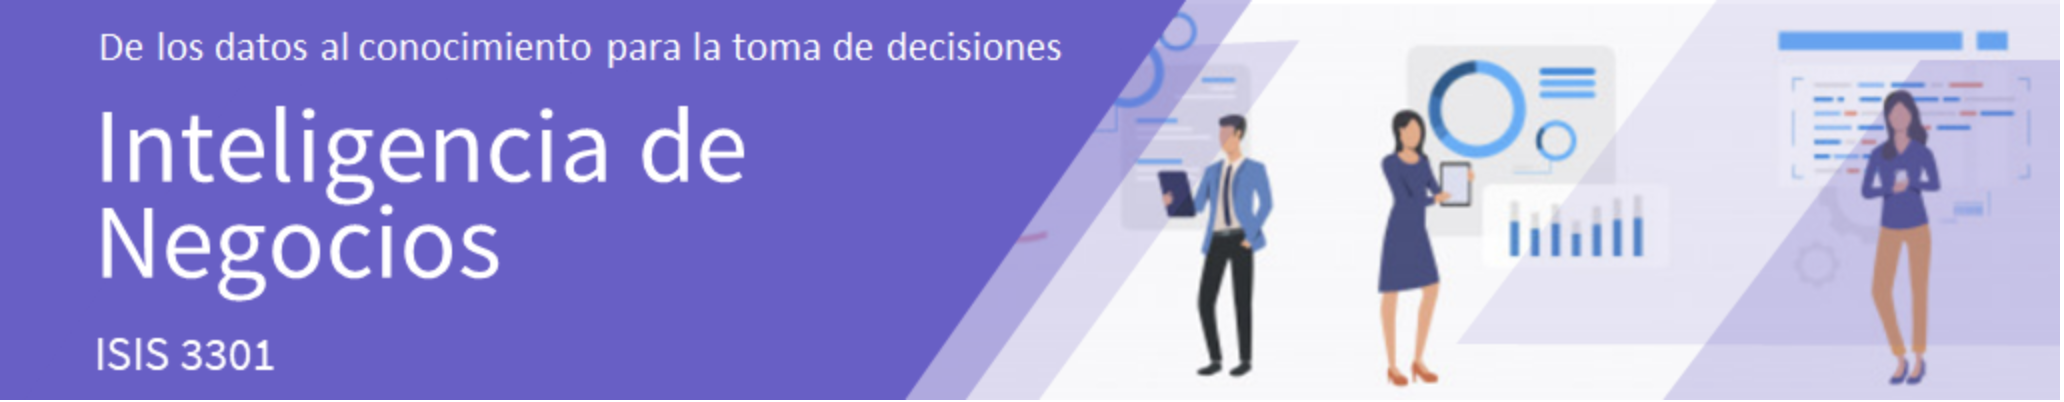

# Laboratorio 1 - Clasificación

### Integrantes:
* Natalia Sanabria Forero - 201532265
* Jorge Andrés Esguerra Alarcón (Dueño de este modelo) - 201719920
* Christian Forigua - 201713023

## 1. Carga

In [16]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

#Random seed

np.random.seed(3301)
db_location = "dataset.csv"


# Sacamos la información de la variable persistida "data" del notebook "DataExploration.ipynb", 
# en una copia para que no se afecte la original y pueda ser reutilizada
%store -r data

model_data = data.copy()



## Nótese que intencionalmente no estamos aplicando normalización al conjunto de datos model_data para el árbol de decisión, dado que este modelo no se ve afectado por normalización de los datos, como si sucede con KNN o MLP.

### Modelo de Decision Tree Classifier

#### La columna objetivo va a ser la columna de outcome donde 1 indica que tiene diabetes y 0 lo contrario.

In [17]:
## Sacamos una variable que tenga los nombres de todos los features menos la clase a predecir.

feature_names = model_data.columns
feature_names = feature_names.drop("outcome")
feature_names = feature_names.tolist()

In [ ]:
## Test-train split
## La distribución por defecto es 75% de las entradas para entrenamiento, el 25% restante para test.

_Más información sobre TestTrain disponible en [este link](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/)_.

In [18]:

X_train, X_test, Y_train, Y_test = train_test_split(model_data[feature_names], model_data['outcome'], random_state=0)

#### Estrategia para escoger la mejor profundidad para el árbol de decisión
De entrada, no hay certeza sobre el hiperparámetro max_depth para nuestro árbol de decisión. 
Tampoco queremos que la profundidad sea muy alta, para evitar sobreajuste en el modelo. 
Por ende, iteraremos sobre profundidades maximas de 2 a 7 nuestro árbol, y nos quedaremos con el mejor árbol.

Recordemos que, cómo se explicó en el cuaderno DataExplorationBusinessContext.ipynb, la métrica a revisar será el recall del modelo.


In [19]:
## Usando RECALL como métrica.

## imports para el modelo y sus métricas de calidad
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import recall_score


## Revisar mejor valor de hiperparámetro max_depth para el modelo, basado en 
## recall score. 
max_depth_range = list(range(2, 8))
recall_scores = []
f1_scores = []

for depth in max_depth_range:
    # Por defecto el criterio es gini.
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    recall_result = recall_score(Y_test, Y_pred)
    recall_scores.append(recall_result)

    
## Mostrar resultados para cada profundidad intentada

max_recall_score = -1
best_depth = -1
for i in range(len(max_depth_range)):
    if recall_scores[i] >= max_recall_score:
        best_depth = i+2
        max_recall_score = recall_scores[i]

print(f"mejor configuración: max_depth = {best_depth}, recall: {max_recall_score}")


mejor configuración: max_depth = 3, recall: 0.6984126984126984


##### Resultado:
De los resultados presentados, vemos que el hiperparámetro max_depth=3 nos otorga el modelo con mejor recall y con mejor f1_score.

En otras palabras, el árbol de decisión con profundidad máxima 3 es el mejor modelo que hemos generado según las restricciones de negocio. 

Por lo tanto, procedemos a plottear el árbol para poder entender qué modelo se constituyó.



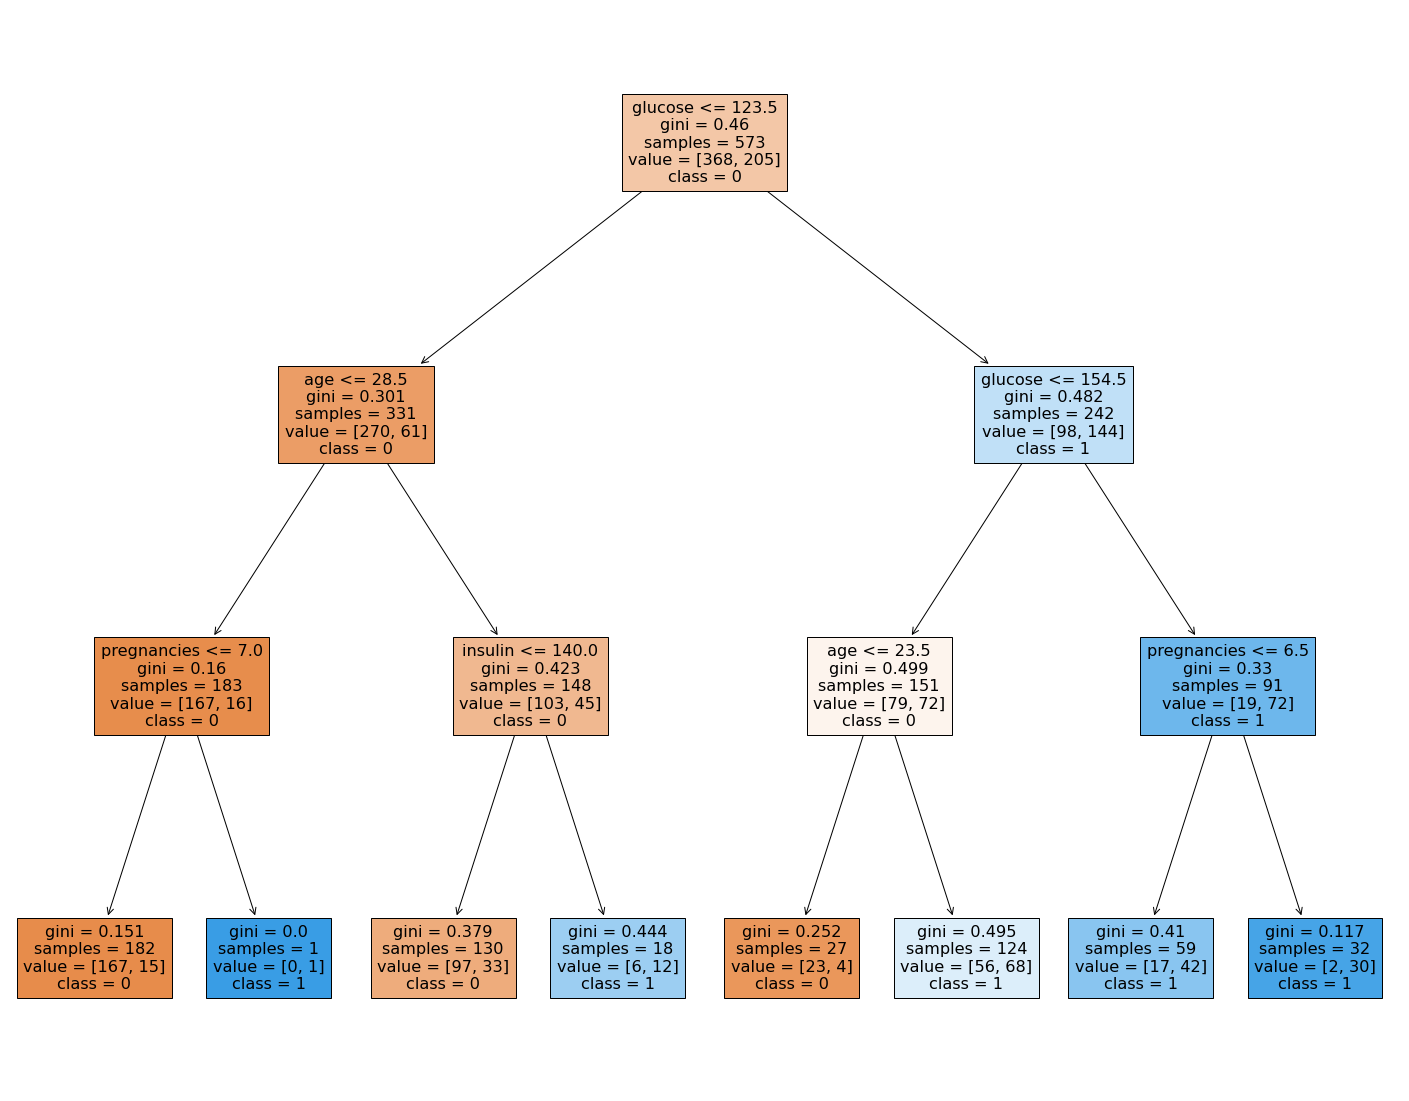

In [20]:
# Calcular explicitamente el mejor árbol

best_tree_clf = DecisionTreeClassifier(max_depth = 3, random_state = 0)
best_tree_clf.fit(X_train, Y_train)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_tree_clf, 
                   feature_names=feature_names,  
                   class_names=["0", "1"],
                   filled=True)

## Explicación del módelo de Árbol de Decisión

### Conceptos:
Se asume que el lector está familiarizado con la estructura de datos de árbol binario.

Raíz: Nódo principal del árbol, simboliza la regla de decisión del primer split que se hará sobre el conjunto de datos inicial. Cobija todos los datos.
Nodo: Nódo del árbol que simboliza una regla de decisión a partir de la cual se seguirá haciendo split del subconjunto de datos del nodo.
Hoja: Nódo del árbol que no representa un split a realizar, sino simplemente un grupo de elementos que quedaron clasificados bajo un conjunto de reglas de decisión. 
Pureza: Propiedad de un grupo de datos, entre más homogeneo sea, será más puro. A mayor heterogeneidad, mayor impureza en el grupo de datos. 
Information Gain (IG): 


El Árbol de decisión es un algoritmo greedy que descubre reglas condicionales para aplicar sobre un conjunto de datos, buscando maximizar la pureza de las hojas. 

Inicialmente, todos los datos están agrupados en un mismo conjunto. El algoritmo intenta determinar cual será la regla de decisión sobre todos los features (la columna o atributo) que maximizará la ganancia de información (Information Gain).

### Formas de calcular la ganancia de información

La ganancia de información es un concepto que depende, en el caso de esta implementación de árboles de decisión, de dos conceptos exclusivamente. 

#### Gini
Por defecto, es el método o criterio que utiliza el DecisionTreeClassifier para maximizar la ganancia de información en el momento de escoger cuál atributo y cual umbral o regla va a aplicar sobre dicho atributo para separar un conjunto impuro de datos, buscando aumentar su pureza.

El gini de un conjunto de datos se calcula como: 
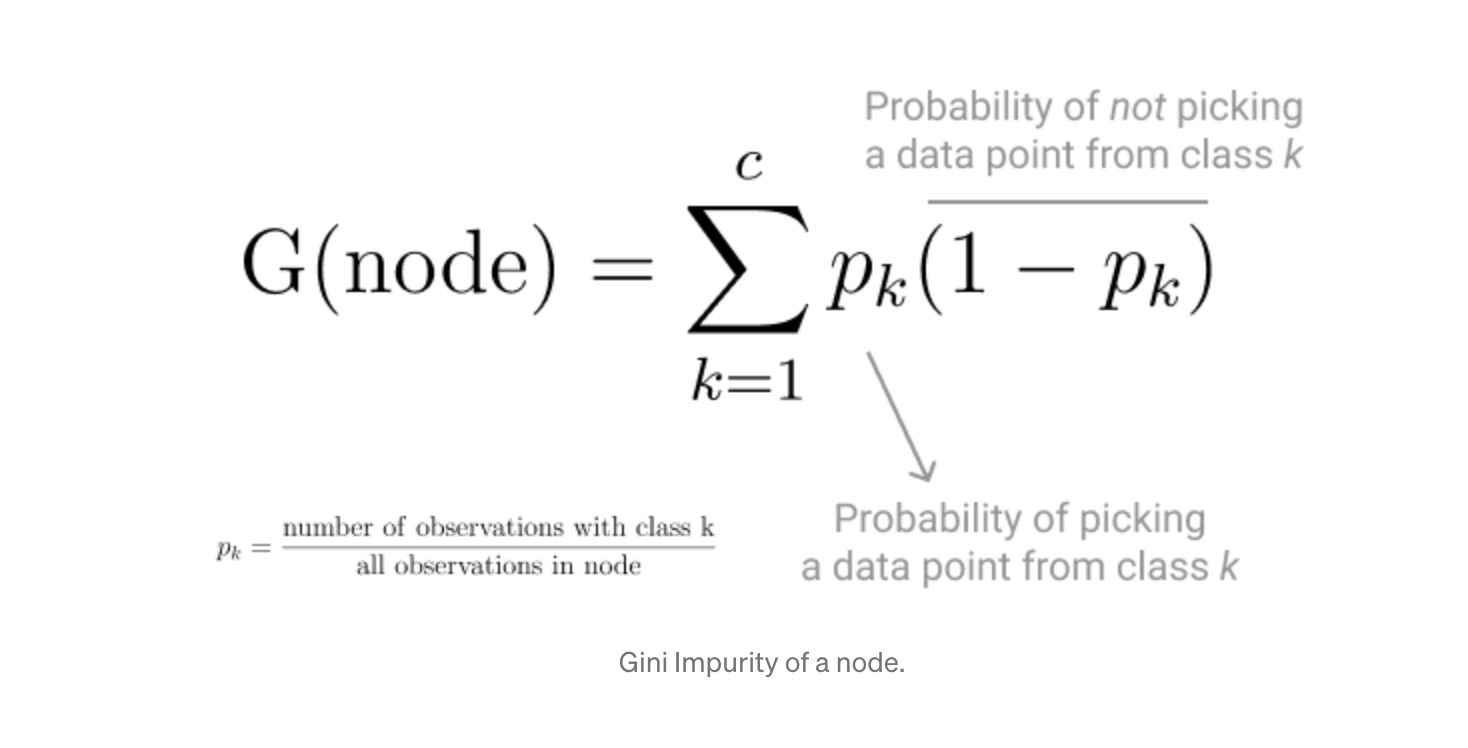
Imagen tomada de: https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575

#### Entropía:
Es el ótro criterio que se puede utilizar en el DecisionTreeClassifier para el paso del algoritmo en donde se busca maximizar la ganancia de información.
Su fórmula es:

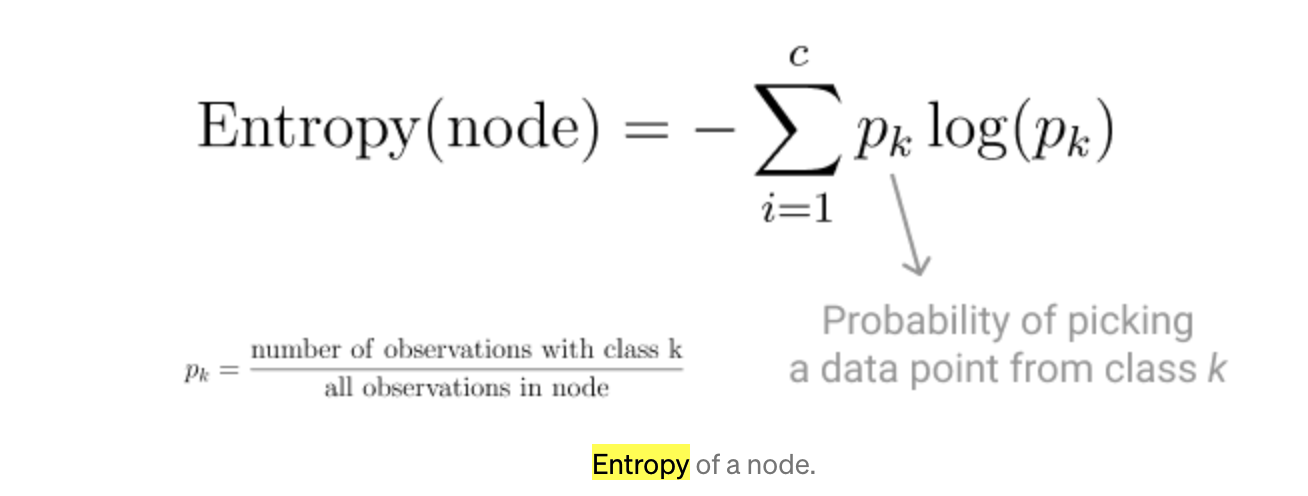
Imagen tomada de: https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b60575


Hay que mencionar que la idea tanto del gini como de la entropía como criterios que se usan en el algoritmo, es que un nodo será splitted (separado) por el clasificador siempre y cuando sea posible cumplir con la siguiente condición:

#### Condición: Un nodo impuro será splitteado siempre que se pueda conseguir que la suma de la entropia/gini de sus dos nodos hijos sea menor a la del nodo padre. 

Esto tiene sentido, dado que lo que queremos es obtener conjuntos puros de datos a partir de reglas de decisión. Con la anterior condición, surge una nueva necesidad. Una de las debilidades del árbol de decisión es que tiende a hacer sobreajuste (overfit) de los datos. De hecho, si dejaramos correr el mismo modelo presentado en este cuaderno sin un parámetro de max_depth, el árbol que propondría el modelo sería completamente ilegible y tendría una profundidad mayor a 10. (No se pone en el cuaderno porque no viene al caso, pero se puede probar quitando el parámetro de max_depth). 

El problema de dejar un árbol de decisión con profundidades altísimas es que generará reglas de decisión demasiado específicas para el conjunto de datos en el que fue entrenado, generando sobreajuste. Esto causará que su rendimiento en datos no conocidos sea pésimo. 

Por esta razón, es importante aplicar un hiperparámetro de max_depth al árbol de decisión que se ajuste a las necesidades del problema y no nos genere sobreajuste. 

#### Información adicional del clasificador:

##### Ventajas:
Es un clasificador fácil de entender. Una ventaja de este modelo es que, dado que podemos forzarlo a que tenga una profundidad máxima, podemos siempre realizar un dibujo del árbol de decisión después de haber sido entrenado. Esto es crucial para que los negocios puedan comprender las razones detrás de las predicciones sobre nuevos datos. 

Es un clasificador sencillo de implementar, y el ajuste de los hiperparámetros es intuitivo. No requiere mayor conocimiento de prerequisito además de tener noción de la estructura de datos de árbol binario.

##### Desventajas: 
Puede generar sobreajuste fácilmente si no se tiene cuidado con el hiperparámetro max_depth.

Nota: La implementación por defecto (es decir, cuando no se especifica el parámetro criterion en el constructor de DecisionTreeClassifier) del árbol de decisión de scikit learn utiliza el criterio de gini por defecto. Esto se debe a que la entropía es más costosa de calcular, ya que la complejidad temporal de la operación de logaritmo no es tiempo constante, mientras que la resta sí. 